In [1]:
import os, glob
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import pickle
import csv

# Collect trial info

In [2]:
# Make sure to update the followings to the correct value
units_input = 425
units_output_upper = 368
units_output_lower = 368 # linear + relu

In [3]:
dir_results = '../results'
flist       = glob.glob(f'{dir_results}/*/*/*.csv')
RESULTS={}
for k, kf in enumerate(flist): # kf = f_csv
    RESULTS[k] = {}
    RESULTS[k]['lot'] = kf.split('/')[-3]
    RESULTS[k]['trial'] = kf.split('/')[-2]
    
    # collect csv data
    # : val loss
    work = pd.read_csv(kf)['val_loss']
    if len(work)!=12:  # -4 is for non-unit hp
        # cheange for unit_11 exist...
        del RESULTS[k] 
        continue
    RESULTS[k]['val_loss'] = np.array(work)
    RESULTS[k]['min_val_loss'] = work.min()
    RESULTS[k]['min_val_loss_epoch'] = work.argmin()+1 # 0-based index
        
    # collect json data
    # : num_layers activation  batch_size optimizer units_{klayer}
    f_json  = f"../results/{RESULTS[k]['lot']}/{RESULTS[k]['trial']}/trial.json"
    with open(f_json) as f:
        work = json.load(f)
    for khp in ['activation','batch_size','num_layers','optimizer']:
        RESULTS[k][khp] = work['hyperparameters']['values'][khp]

    # check the sanity of trial.json (for unit)
    
    # if False: #len(work['hyperparameters']['values'])-4 != 12:
    if f"units_{RESULTS[k]['num_layers']-1}" not in work['hyperparameters']['values'].keys():
        # print('ERROR (%s, %s)'%(RESULTS[k]['lot'], RESULTS[k]['trial']))
        del RESULTS[k]
        continue
    else:
        units = np.array( [work['hyperparameters']['values']['units_%d'%(k)] 
                           for k in range(RESULTS[k]['num_layers'])] )
        RESULTS[k]['units'] = units
    

    # Add Num_Params
    # WORK HERE 
    # to do
    # - add lower output layer params.
    layers = np.array([units_input, *units, units_output_upper, units_output_lower])
    RESULTS[k]['num_parameters'] = np.sum((layers[:-1]+1) * layers[1:])
    
RESULTS_PD = pd.DataFrame(RESULTS).transpose()

In [4]:
# save RESULTS_PD to csv after sorting by val_loss
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))
RESULTS_PD.to_csv('step1_results_v2.csv')

4421


# Visualization (HP vs. min val loss)

top 10% (blue) and top 1% (orange) models

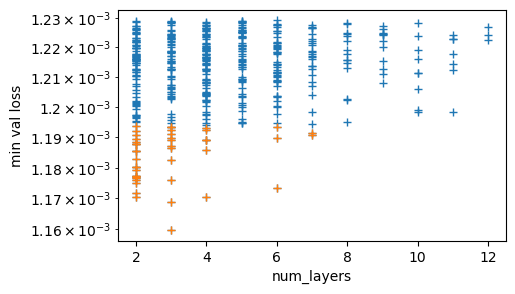

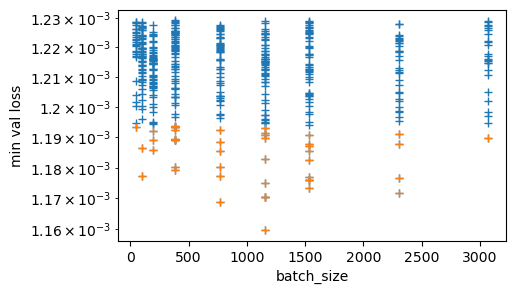

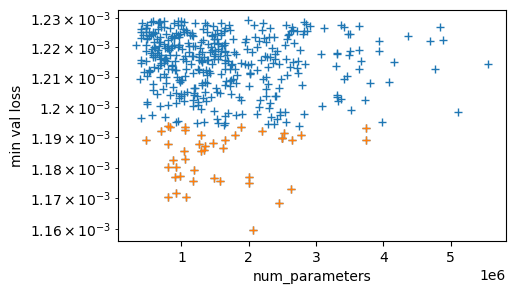

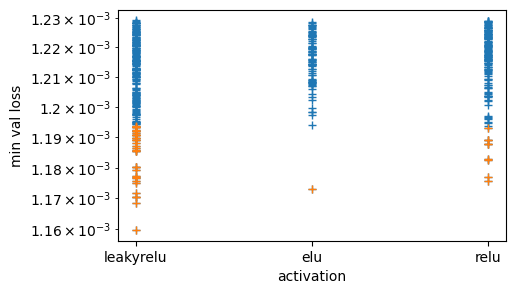

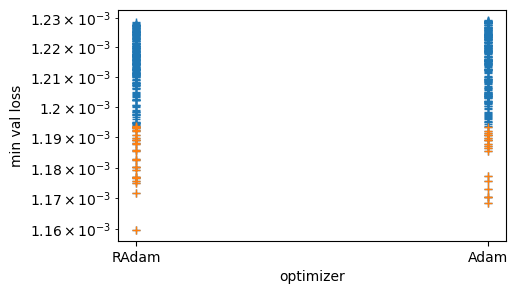

In [5]:
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_10p, th_loss_1p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

top 99% (blue) and top 1% (orange) models

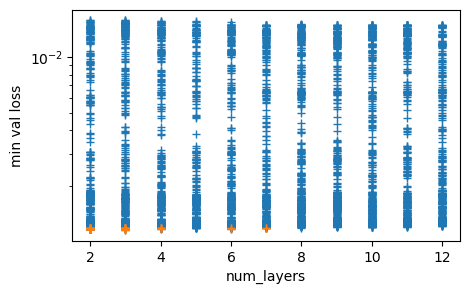

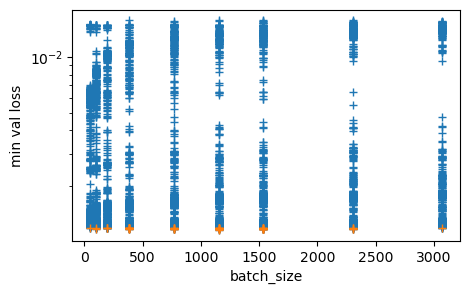

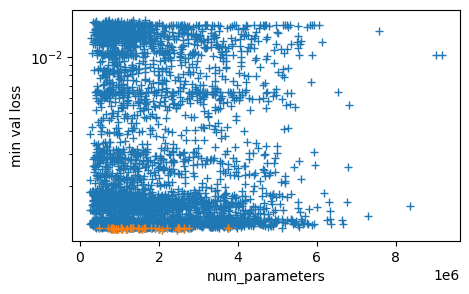

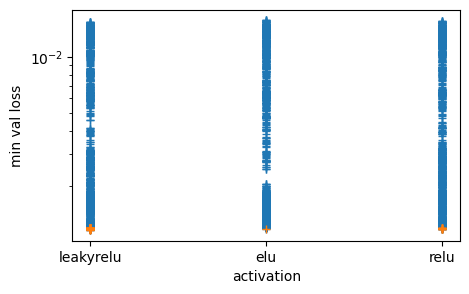

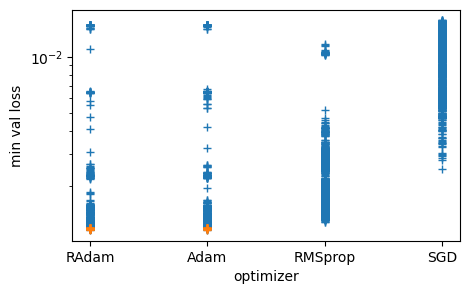

In [6]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_99p, th_loss_1p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

num_params vs. num_layers

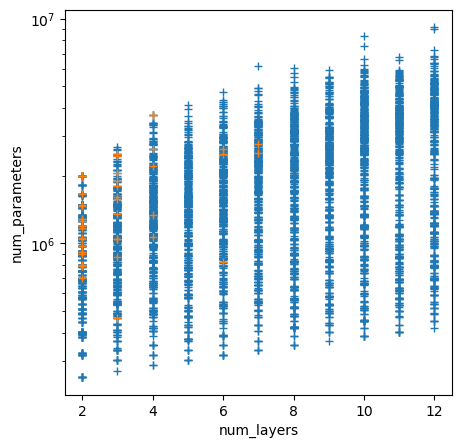

In [7]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 10%

kvar_y='num_parameters'
kvar_x='num_layers'
fig, ax = plt.subplots()
for kth in [th_loss_99p, th_loss_1p]:
    ploty = RESULTS_PD['min_val_loss']
    indy = ploty<kth
    ploty = RESULTS_PD[kvar_y]
    ploty = ploty[indy]
    plotx = RESULTS_PD[kvar_x]
    plotx = plotx[indy]
    ax.plot(plotx,ploty, ls='none', marker='+')
ax.set_yscale('log')
ax.set_xlabel(kvar_x)
ax.set_ylabel(kvar_y)
fig.set_size_inches(5,5)



# Pick the best models

In [8]:
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))

4421


In [9]:
TOP44 = RESULTS_PD.iloc[:44]
# TOP44['trial'].to_csv('top44.trial.v2.txt', sep='\n') # then, grep 'trial_'
# TOP44['lot'].to_csv('top44.lot.v2.txt', sep='\n')     # then, grep 'lot-'
TOP44

,lot,trial,val_loss,min_val_loss,min_val_loss_epoch,activation,batch_size,num_layers,optimizer,units,num_parameters
3282,lot-42,trial_0068,"[0.0014575669774785, 0.0013742457376793, 0.001...",0.00116,12,leakyrelu,1152,3,RAdam,"[640, 768, 1024]",2065376
1768,lot-31,trial_0062,"[0.0013976225163787, 0.0013451551785692, 0.001...",0.001169,12,leakyrelu,768,3,Adam,"[896, 896, 896]",2455008
210,lot-48,trial_0021,"[0.0014388927957043, 0.0013737544650211, 0.001...",0.001171,12,leakyrelu,1152,4,Adam,"[512, 512, 256, 512]",1068256
1560,lot-59,trial_0072,"[0.0014743177453055, 0.0013550563016906, 0.001...",0.001171,12,leakyrelu,1152,2,Adam,"[256, 896]",805216
1475,lot-39,trial_0021,"[0.001602264936082, 0.0015021373983472, 0.0013...",0.001172,12,leakyrelu,2304,2,RAdam,"[512, 640]",918112
1691,lot-26,trial_0050,"[0.0015493938699364, 0.0014419227372854, 0.001...",0.001173,12,elu,1536,6,Adam,"[640, 512, 1024, 896, 384, 128]",2621536
411,lot-35,trial_0029,"[0.0014930722536519, 0.0013995573390275, 0.001...",0.001175,12,leakyrelu,1152,2,RAdam,"[1024, 1024]",1998816
3014,lot-55,trial_0042,"[0.0025451087858527, 0.0024447189643979, 0.002...",0.001176,12,leakyrelu,1536,2,RAdam,"[896, 512]",1165536
2669,lot-25,trial_0046,"[0.0014968222239986, 0.0012502218596637, 0.001...",0.001176,12,relu,1536,3,Adam,"[384, 640, 1024]",1579360
4164,lot-08,trial_0074,"[0.0015760414535179, 0.0013925092061981, 0.001...",0.001176,12,leakyrelu,2304,2,RAdam,"[768, 896]",1482080
